# Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sn
from statsmodels.formula.api import ols

# Prep Data

In [3]:
# import data into local dataframes 
filepath = '../data/data-case.xlsx'
df_users = pd.read_excel(filepath, sheet_name='users')
df_nps = pd.read_excel(filepath, sheet_name='nps')
df_appts = pd.read_excel(filepath, sheet_name='appointments')

# visualize dataframes
df_users.head()

# uncomment and run last to visualize
# df_nps.head()
# df_appts.head()

,user_id,gender,birth_date,start_date,end_date,city_code
0,1,female,1981-07-07,2010-06-29,2010-11-02,3
1,2,male,1996-10-08,2011-01-18,2012-02-18,1
2,3,female,1986-06-03,2010-01-13,2010-09-12,3
3,4,male,1992-07-28,2010-11-19,2012-08-01,3
4,5,male,1981-04-21,2011-08-27,2011-12-11,2


In [4]:
""" Extend `df_users` by adding the total number days a user has been a client.
    This is the variable we care about. 
    
    num_days = end_date - start_date, end date inclusive
"""
df_users['num_days'] = df_users['end_date'] - df_users['start_date']
df_users['num_days'] = df_users['num_days'].dt.days
df_users.head()

,user_id,gender,birth_date,start_date,end_date,city_code,num_days
458,459,male,1994-09-26,2010-09-08,2011-08-28,3,354
459,460,male,1986-05-04,2011-08-17,2013-05-08,4,630
460,461,male,1996-01-29,2011-06-18,2012-01-29,3,225
461,462,male,1984-03-27,2011-01-14,2013-06-29,3,897
462,463,female,1995-12-31,2010-09-05,2011-03-26,3,202


Text(0.5, 1.0, 'Distribution of days over the entire dataset')

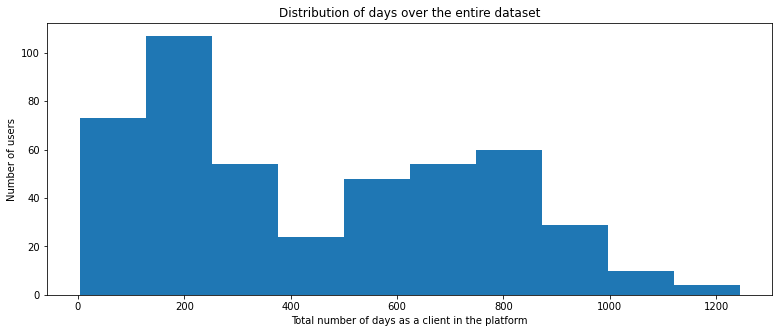

In [59]:
# Visualize distribution of days spent in the platform
plt.figure(figsize=(13,5))
ax = df_users['num_days'].plot.hist()

# Set common labels
ax.set_xlabel('Total number of days as a client in the platform')
ax.set_ylabel('Number of users')
ax.set_title('Distribution of days over the entire dataset')

# Average time between appts

In [61]:
df = df_appts.copy()
df['time_diff'] = 0 #initialize column to assign running time diff

# sort dates
df.sort_values(by = ['user_id', 'appointment_date'])

# compute diff
for i in range(df.shape[0] - 1):
    df['time_diff'][i+1] = (df['appointment_date'][i+1] - df['appointment_date'][i]).days
    
# drop negatives
df.loc[df.time_diff < 0, "time_diff"] = 0

df.head()

/Users/Georgia/Desktop/case-cuidas/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,appt_id,user_id,appointment_date,channel,type,time_diff
0,1,1,2010-08-10,chat,first,0
1,2,1,2010-10-29,chat,regular,80
2,3,2,2011-06-18,presential,first,232
3,4,2,2011-10-24,chat,regular,128
4,5,2,2011-12-29,chat,regular,66


In [62]:
# compute number of appts
df2 = df_appts.copy()
df2 = df2.groupby('user_id', as_index=False).count()
df2 = df2.drop(columns=['appt_id', 'appointment_date', 'channel'])
df2 = df2.rename(columns={"type": "num_appts"})

In [63]:
# sum total days
df = df.groupby('user_id').sum()
df = df.drop(columns=['appt_id'])
df = df.reset_index()

In [65]:
df3 = df.copy()
df3['num_appts'] = df2['num_appts']
df3['avg_time'] = df3['time_diff']/df3['num_appts']
df3['num_days'] = df_users['num_days']
df3.head()

,user_id,time_diff,num_appts,avg_time,num_days
0,1,80,2,40.000,126
1,2,476,7,68.000,396
2,3,81,4,20.250,242
3,4,1447,8,180.875,621
4,5,0,1,0.000,106


Text(0.5, 1.0, 'Distribution of average time between appointments')

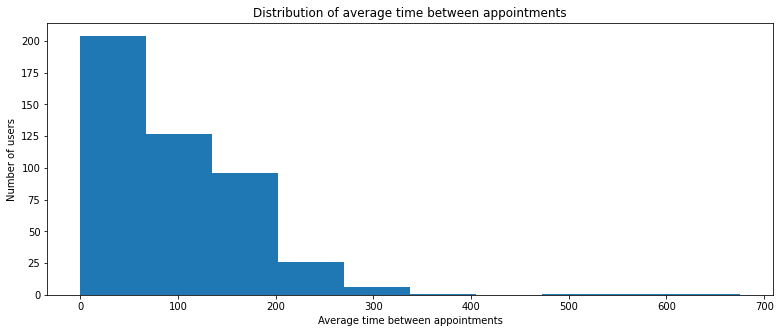

In [68]:
plt.figure(figsize=(13,5))
ax = df3['avg_time'].plot.hist()

# Set common labels
ax.set_xlabel('Average time between appointments')
ax.set_ylabel('Number of users')
ax.set_title('Distribution of average time between appointments')

Text(0.5, 1.0, 'avg_time vs num_days')

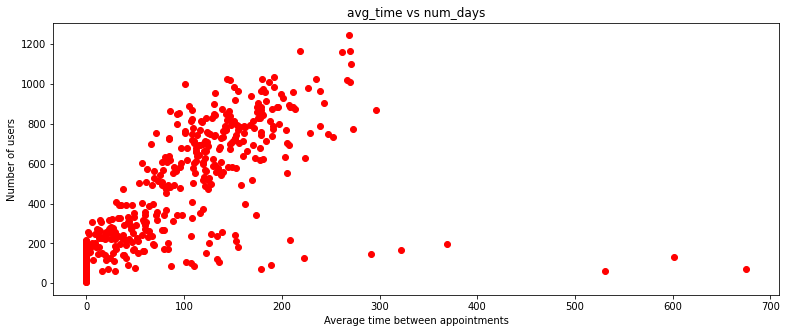

In [73]:
# plot avg_time vs num_days
plt.figure(figsize=(13,5))
ax = plt.plot(df3['avg_time'], df3['num_days'], 'ro')

# Set common labels
plt.xlabel('Average time between appointments')
plt.ylabel('Number of users')
plt.title('avg_time vs num_days')

In [74]:
model = ols('num_days ~ avg_time', data=df3)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     308.5
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.05e-53
Time:                        05:36:37   Log-Likelihood:                -3183.7
No. Observations:                 463   AIC:                             6371.
Df Residuals:                     461   BIC:                             6380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    241.4328     16.075     15.019      0.000     209.843     273.023
avg_time       2.2470      0.128     17.563      0.000       1.996       2.498
==============================================================================
Omnibus:                      231.539   Durbin-Watson:                   2.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2509.473
Skew:                          -1.891   Prob(JB):                         0.00
Kurtosis:                      13.760   Cond. No.                         185.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Deep dive #1: Group by user permanence 

In [75]:
df = df3.copy()
mean = df['num_days'].mean()
top = df[df['num_days'] >= mean] # inclusive
bottom = df[df['num_days'] < mean]
top.head()

,user_id,time_diff,num_appts,avg_time,num_days
3,4,1447,8,180.875000,621
5,6,499,6,83.166667,493
7,8,1583,9,175.888889,907
9,10,929,9,103.222222,618
11,12,1545,11,140.454545,762


## 50% Top users

Text(0.5, 1.0, 'Distribution over top 50% users')

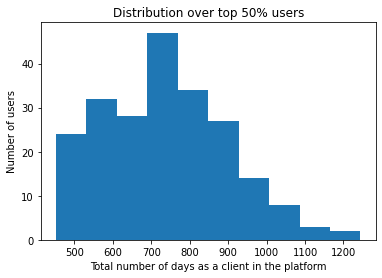

In [76]:
ax = top['num_days'].plot.hist()

# Set common labels
ax.set_xlabel('Total number of days as a client in the platform')
ax.set_ylabel('Number of users')
ax.set_title('Distribution over top 50% users')

Text(0.5, 1.0, 'avg_time vs num_days')

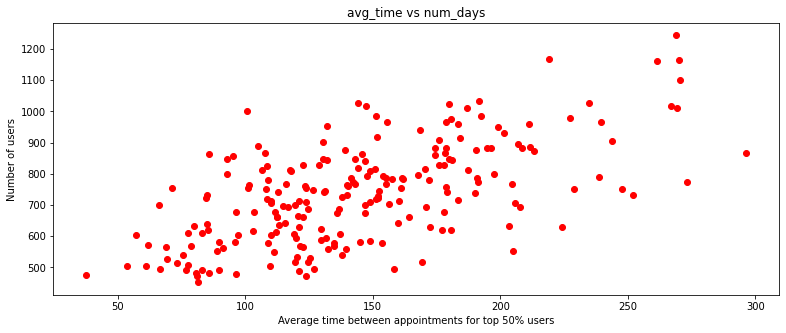

In [77]:
plt.figure(figsize=(13,5))
ax = plt.plot(top['avg_time'], top['num_days'], 'ro')

# Set common labels
plt.xlabel('Average time between appointments for top 50% users')
plt.ylabel('Number of users')
plt.title('avg_time vs num_days')

In [78]:
model = ols('num_days ~ avg_time', data=top)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     136.4
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           9.07e-25
Time:                        05:39:29   Log-Likelihood:                -1367.4
No. Observations:                 219   AIC:                             2739.
Df Residuals:                     217   BIC:                             2745.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    449.4081     26.065     17.242      0.000     398.035     500.781
avg_time       1.9896      0.170     11.678      0.000       1.654       2.325
==============================================================================
Omnibus:                        1.601   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.449   Jarque-Bera (JB):                1.564
Skew:                           0.123   Prob(JB):                        0.457
Kurtosis:                       2.667   Cond. No.                         472.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 50% Bottom users

Text(0.5, 1.0, 'Distribution over bottom 50% users')

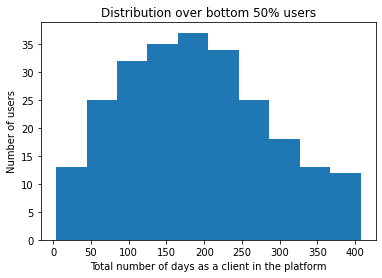

In [79]:
ax = bottom['num_days'].plot.hist()

# Set common labels
ax.set_xlabel('Total number of days as a client in the platform')
ax.set_ylabel('Number of users')
ax.set_title('Distribution over bottom 50% users')

Text(0.5, 1.0, 'avg_time vs num_days')

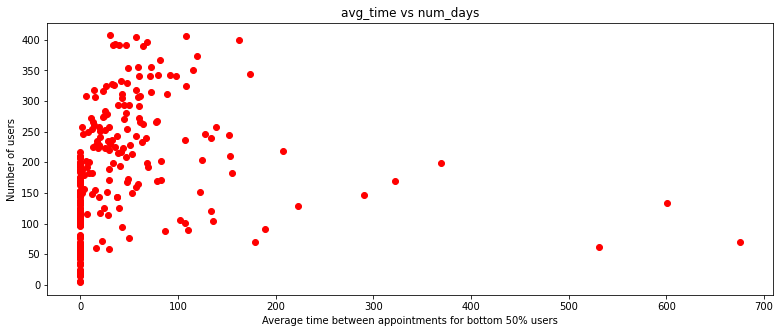

In [80]:
plt.figure(figsize=(13,5))
ax = plt.plot(bottom['avg_time'], bottom['num_days'], 'ro')

# Set common labels
plt.xlabel('Average time between appointments for bottom 50% users')
plt.ylabel('Number of users')
plt.title('avg_time vs num_days')

In [81]:
model = ols('num_days ~ avg_time', data=bottom)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.643
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.105
Time:                        05:40:40   Log-Likelihood:                -1461.8
No. Observations:                 244   AIC:                             2928.
Df Residuals:                     242   BIC:                             2935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    184.0068      7.075     26.009      0.000     170.071     197.943
avg_time       0.1216      0.075      1.626      0.105      -0.026       0.269
==============================================================================
Omnibus:                       10.782   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                6.399
Skew:                           0.226   Prob(JB):                       0.0408
Kurtosis:                       2.348   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Deep dive #2: Percentage of appointment type

In [82]:
# compute number of appts
df = df_appts.copy()
df = df.groupby('user_id', as_index=False).count()
df = df.drop(columns=['appt_id', 'appointment_date', 'channel'])
df = df.rename(columns={"type": "num_appts"})

# compute number of chat appointments
df2 = df_appts.copy()
df2['num_chat'] = 0
df2.loc[df2.channel == 'chat', 'num_chat'] = 1
df2 = df2.groupby('user_id', as_index=False)['num_chat'].sum()

df['num_chat'] = df2['num_chat']
df['p_chat'] = df['num_chat']/df['num_appts']
df['p_presential'] = 1.0 - df['p_chat']
df['num_days'] = df3['num_days']
df.head()

,user_id,num_appts,num_chat,p_chat,p_presential,num_days
0,1,2,2,1.000000,0.000000,126
1,2,7,3,0.428571,0.571429,396
2,3,4,4,1.000000,0.000000,242
3,4,8,3,0.375000,0.625000,621
4,5,1,1,1.000000,0.000000,106


## Chat appointments

Text(0.5, 1.0, 'p_chat vs num_days')

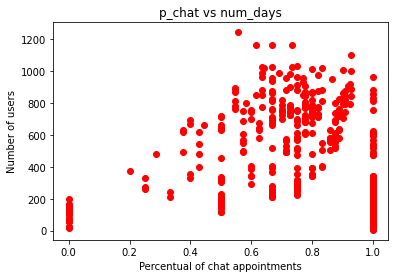

In [85]:
ax = plt.plot(df['p_chat'], df['num_days'], 'ro')

# Set common labels
plt.xlabel('Percentual of chat appointments')
plt.ylabel('Number of users')
plt.title('p_chat vs num_days')

In [86]:
model = ols('num_days ~ p_chat', data=df)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04507
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.832
Time:                        05:43:05   Log-Likelihood:                -3302.3
No. Observations:                 463   AIC:                             6609.
Df Residuals:                     461   BIC:                             6617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    457.3103     43.268     10.569      0.000     372.284     542.337
p_chat       -11.4961     54.149     -0.212      0.832    -117.906      94.914
==============================================================================
Omnibus:                      251.839   Durbin-Watson:                   3.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.790
Skew:                           0.344   Prob(JB):                     1.69e-08
Kurtosis:                       1.825   Cond. No.                         6.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Presential appointments

Text(0.5, 1.0, 'p_presential vs num_days')

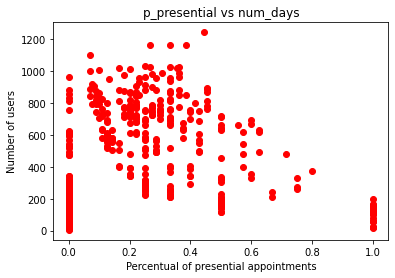

In [87]:
ax = plt.plot(df['p_presential'], df['num_days'], 'ro')

# Set common labels
plt.xlabel('Percentual of presential appointments')
plt.ylabel('Number of users')
plt.title('p_presential vs num_days')

In [88]:
model = ols('num_days ~ p_presential', data=df)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04507
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.832
Time:                        05:43:43   Log-Likelihood:                -3302.3
No. Observations:                 463   AIC:                             6609.
Df Residuals:                     461   BIC:                             6617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      445.8142     19.351     23.038      0.000     407.787     483.842
p_presential    11.4961     54.149      0.212      0.832     -94.914     117.906
==============================================================================
Omnibus:                      251.839   Durbin-Watson:                   3.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.790
Skew:                           0.344   Prob(JB):                     1.69e-08
Kurtosis:                       1.825   Cond. No.                         4.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""